## **DSAA6100 Week3 - Computer Vision - Lab1**

<ul>
    <b>Content</b>:
    <li>Image Classification using CNN</li>
</ul>

# **Image Classification using CNN**

## **Import libraries**

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt

### **Set the random seed**

In [ ]:
np.random.seed(0)
torch.manual_seed(0)

### **Set GPU**

In [ ]:
# Make sure you're using cuda (GPU) by checking the hardware accelerator under Runtime -> Change runtime type
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using:", device)

We're using: cuda


### **Download and extract the data**

In [ ]:
%%capture
!pip install -U gdown

In [ ]:
!gdown 1vacRphjb47LXifcd3F2xlsOTKR0R_LiF

Downloading...
From (uriginal): https://drive.google.com/uc?id=1vacRphjb47LXifcd3F2xlsOTKR0R_LiF
From (redirected): https://drive.google.com/uc?id=1vacRphjb47LXifcd3F2xlsOTKR0R_LiF&confirm=t&uuid=0f157e2b-0b83-45e4-8b41-1f4a7b8369f9
To: /content/supertuxkart_data.zip
100% 46.2M/46.2M [00:00<00:00, 78.9MB/s]


In [ ]:
%%capture
!yes N | unzip "/content/supertuxkart_data.zip" -d "/content"

## **Dataset class implementation**

In this section, you will be training, validating and testing a CNN model to classify images of objects from a car racing video game called SuperTuxKart. There are 6 classes of objects: kart is 1, pickup is 2, nitro is 3, bomb is 4 and projectile 5. The background class (all other images) is assigned the label 0. First, you need to load data in a way that PyTorch can deal with easily. We will lean on PyTorch’s `Dataset` class to do this.

Complete the `STKDataset` class that inherits from `Dataset`.

1. `__init__` is a constructor, and would be the natural place to perform operations common to the full dataset, such as parsing the labels and image paths.
2. The `__len__` function should return the size of the dataset, i.e., the number of samples.
3. The `__getitem__` function should return a python tuple of (image, label). The image should be a torch.Tensor of size (3, 64, 64) and the label should be an int.

The labels of the images under a particular folder (`train/` or `val/`) are stored in the same folder as `labels.csv`. Read the `labels.csv` file using `pandas` to understand what it looks like before proceeding. There is also a `labels.csv` in the `test/` folder. That would only contain the file names of the test samples.

In [ ]:
ENCODING_TO_LABELS = {0: "background",
                    1: "kart",
                    2: "pickup",
                    3: "nitro",
                    4: "bomb",
                    5: "projectile"}

LABELS_TO_ENCODING = {"background": 0,
                    "kart": 1,
                    "pickup": 2,
                    "nitro": 3,
                    "bomb": 4,
                    "projectile": 5}

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import os

LABELS_TO_ENCODING = {"background": 0, "kart": 1, "pickup": 2, "nitro": 3, "bomb": 4, "projectile": 5}

class STKDataset(Dataset):

    def __init__(self, image_path, transform=None):
        self.image_path = image_path
        self.labels = pd.read_csv(os.path.join(image_path, "labels.csv"))
        self.transform = transform

    def __len__(self):
        # STUDENT TODO START: Return the number of samples in the dataset
        ...
        # STUDENT TODO END

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        # STUDENT TODO START: Create the path to each image by joining the root path with the name of the file as found in labels.csv
        img_name = ...
        # STUDENT TODO END

        # Read the image from the file path
        image = Image.open(img_name)
        # Transform the image using self.transform
        if self.transform:
            image = self.transform(image)

        if "label" in self.labels.columns:
            # STUDENT TODO START: Extract label name and encode it using the LABELS_TO_ENCODING dictionary
            label_name = ...
            label = ...
            # STUDENT TODO END
            sample = (image, label)
        else:
            sample = (image)
        return sample

In [ ]:

# STUDENT TODO START: Use transforms.Compose to transform the image such that every pixel takes on a value between -1 and 1
# Hint: Refer to transforms.ToTensor() and transforms.Normalize()
# Using transforms.Compose to chain together ToTensor and Normalize
transform = ...
# STUDENT TODO END

train_dataset = STKDataset(image_path="train", transform=transform)
val_dataset = STKDataset(image_path="val", transform=transform)
test_dataset = STKDataset(image_path="test", transform=transform)

### **Visualization**

The following cell visualizes the data as a sanity check for your implementation of the `STKDataset` class.

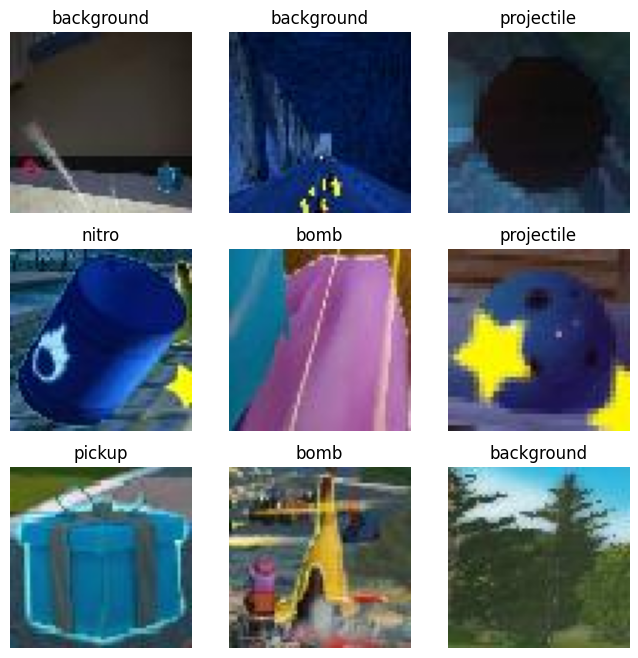

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
torch.manual_seed(0)
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(ENCODING_TO_LABELS[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0)*0.5 + 0.5)
plt.show()

### **Data loaders**

In [ ]:
from torch.utils.data import DataLoader

# STUDENT TODO START: Create data loaders for training, validation, and test sets each having a batch size of 64.
# Set shuffle to be True for training and validation data loaders, False for test data loader.
train_dataloader = ...
val_dataloader = ...
test_dataloader = ...
# STUDENT TODO END

## **CNN architecture**

Your goal is to devise a CNN that passes the threshold accuracy (80%) on the test set. You get full score (20 pts) if you get at least 80% test set accuracy and 0 if you get 30% or below. The score varies linearly between 0 and 20 for accuracies between 30% and 80%.

There are several decisions that you take in building your CNN including but not limited to:

- the number of convolutional layers
- the kernel size, stride, padding and number of out channels for each convolutional layer
- number of fully connected layers
- number of nodes in each fully connected layer

You are free to decide the architecture. To make your search easier, we recommend you to use not more than four convolutional layers and four fully connected layers. We also suggest that you use the relu activation function between the layers.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    # STUDENT TODO START: Create the layers of your CNN here

    ...

    # STUDENT TODO END

  def forward(self, x):

    # STUDENT TODO START: Perform the forward pass through the layers
    ...
    # STUDENT TODO END


# STUDENT TODO START: Create an instance of Net and move it to the GPU
# Create an instance of the Net and move it to the GPU if available
device = ...
model = ...
# STUDENT TODO END


## **Training, validation, and testing**

In [ ]:
import torch.optim as optim

# 1. Set the criterion to be cross entropy loss
criterion = ...

# 2. Experiment with different optimizers
# Using the Adam optimizer
optimizer = ...

# Alternatively, you could use SGD or other optimizers like this:
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
train_loss, validation_loss = [], []
train_acc, validation_acc = [], []

# STUDENT TODO START:
# Note that we have set the number of epochs to be 5. You can choose to increase or decrease the number of epochs.
num_epochs = 5
for epoch in range(num_epochs):

    model.train()
    running_loss = 0.
    correct, total = 0, 0

    for i, data in enumerate(train_dataloader, 0):

        inputs, labels = data
        # 1. Store the inputs and labels in the GPU
        inputs = ...
        labels = ...

        # 2. Get the model predictions
        predictions = ...

        # 3. Zero the gradients out
        ...

        # 4. Get the loss
        loss = ...

        # 5. Calculate the gradients
        ...

        # 6. Update the weights
        ...

        running_loss += loss.item()

        _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(running_loss / len(train_dataloader))
    train_acc.append(correct/total)

    model.eval()
    running_loss = 0.
    correct, total = 0, 0

    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for i, data in enumerate(val_dataloader, 0):

            inputs, labels = data
            # 1. Store the inputs and labels in the GPU
            inputs = ...
            labels = ...

            # 2. Get the model predictions
            predictions = ...

            # 3. Get the loss
            loss = ...

            running_loss += loss.item()

            _, predicted = torch.max(predictions, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    validation_loss.append(running_loss / len(val_dataloader))
    validation_acc.append(correct/total)

    print(f"Epoch {epoch+1}:")
    print(f"Training Loss:", round(train_loss[epoch], 3))
    print(f"Validation Loss:", round(validation_loss[epoch], 3))
    print(f"Training Accuracy:", round(train_acc[epoch], 3))
    print(f"Validation Accuracy:", round(validation_acc[epoch], 3))
    print("------------------------------")

Epoch 1:
Training Loss: 0.623
Validation Loss: 0.379
Training Accuracy: 0.76
Validation Accuracy: 0.867
------------------------------
Epoch 2:
Training Loss: 0.234
Validation Loss: 0.371
Training Accuracy: 0.918
Validation Accuracy: 0.875
------------------------------
Epoch 3:
Training Loss: 0.144
Validation Loss: 0.54
Training Accuracy: 0.952
Validation Accuracy: 0.818
------------------------------
Epoch 4:
Training Loss: 0.096
Validation Loss: 0.345
Training Accuracy: 0.967
Validation Accuracy: 0.886
------------------------------
Epoch 5:
Training Loss: 0.082
Validation Loss: 0.36
Training Accuracy: 0.973
Validation Accuracy: 0.89
------------------------------


In [ ]:
model.eval()

test_predictions_list = []

for inputs in test_dataloader:  # Iterating directly over images
    # STUDENT TODO START:
    # 1. Move the inputs to the GPU
    inputs = ...

    # 2. Get the model predictions
    predictions = ...
    # STUDENT TODO END

    _, predicted = torch.max(predictions, 1)

    test_predictions_list.append(predicted.cpu())

test_predictions = torch.cat(test_predictions_list).numpy()
print("First 20 predictions:")
print(test_predictions[:20])

First 20 predictions:
[1 0 5 3 4 0 1 4 4 5 3 3 2 3 0 3 3 4 3 5]
